#   <center> Taller  de Aprendizaje Automático </center>
##  <center> Proyecto 2: Freesound Audio Tagging 2019  </center>
### <center> Valentina Chagas 51346194  </center>
### <center> Camila Pérez 50087381  </center>
### <center> Florencia Roque 50902197  </center>

## Imports:

In [ ]:
!pip install comet_ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2


In [1]:
#from comet_ml import Experiment
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
seed = 42
from google.colab import files
from sklearn.model_selection import train_test_split

Kaggle

In [2]:
!pip install kaggle

import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


## Descarga de datos

Empezamos trabajando con los datos curated

Para trabajar con los archivos resampled, subirlos acá:

In [ ]:
# Cargar acá los archivos de train_curated_resampled
uploaded_resampled = files.upload()

Obtener datos de Google Drive

In [3]:
from google.colab import drive
import os
import zipfile

# Montar Drive (solo si no está montado)
drive_path = '/content/drive'
if not os.path.ismount(drive_path):
    drive.mount(drive_path)

# Ruta a la carpeta compartida
base_path = os.path.join(drive_path, 'MyDrive', 'Proyecto2_TAA')
assert os.path.exists(base_path), f"No se encontró la carpeta {base_path}"

# Verificar archivos .zip
zip_files = [f for f in os.listdir(base_path) if f.endswith('.zip')]
print("Archivos .zip encontrados:", zip_files)

# Verificar archivos .csv
csv_files = [f for f in os.listdir(base_path) if f.endswith('.csv')]
print("Archivos .csv encontrados:", csv_files)

# Descomprimir si es necesario
for zip_name in zip_files:
    zip_path = os.path.join(base_path, zip_name)
    extract_path = os.path.join(base_path, zip_name.replace('.zip', ''))

    if not os.path.exists(extract_path):
        print(f"Extrayendo {zip_name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"{zip_name} extraído en {extract_path}")
    else:
        print(f"{zip_name} ya estaba extraído.")


Mounted at /content/drive
Archivos .zip encontrados: ['test_resampled.zip', 'train_curated_resampled.zip', 'train_noisy_resampled.zip']
Archivos .csv encontrados: ['sample_submission_v24.csv', 'train_curated.csv', 'train_noisy.csv', 'vocabulary.csv']
test_resampled.zip ya estaba extraído.
train_curated_resampled.zip ya estaba extraído.
train_noisy_resampled.zip ya estaba extraído.


Para trabajar con los archivos sin resamplear:

In [4]:
!kaggle competitions download -c freesound-audio-tagging-2019 -f train_curated.csv
#!kaggle competitions download -c freesound-audio-tagging-2019 -f train_curated.zip
#!unzip train_curated.zip -d train_curated

  0% 0.00/140k [00:00<?, ?B/s]
100% 140k/140k [00:00<00:00, 388MB/s]


Vamos a agregar a cada muestra, su filepath

In [5]:
# Cargar CSV
df = pd.read_csv("train_curated.csv")

# Separar etiquetas (están separadas por comas)
df["labels"] = df["labels"].apply(lambda x: x.split(",")) # si es dog,bark queda ["dog", "bark"]

# Binarizar etiquetas, te queda un vector con todas las labels posibles y pone un 1 si esa label esta en ese audio
mlb = MultiLabelBinarizer() # si las etiquetas posibles son ['dog', 'bark', 'car'], y
                            # un audio tiene ['dog', 'car'], el vector resultante será [1, 0, 1]
y = mlb.fit_transform(df["labels"])  # y.shape = (num_files, num_labels)
class_names = mlb.classes_  # Guarda la lista completa de etiquetas posibles,
                            # sirve para luego interpretar qué etiqueta corresponde a cada posición del vector
# Construir ruta completa y segura para cada archivo de audio usando pathlib
audio_dir = Path("/content/drive/MyDrive/Proyecto2_TAA/train_curated_resampled/train_curated_resampled")

# Construir ruta completa y segura para cada archivo de audio usando pathlib
df["filepath"] = df["fname"].apply(lambda x: audio_dir / x)
# Convertir objetos Path a string para compatibilidad con otras librerías
df["filepath"] = df["filepath"].astype(str)

In [6]:
inner_path = Path("/content/drive/MyDrive/Proyecto2_TAA/train_curated_resampled/train_curated_resampled")

print("Contenido dentro de la subcarpeta:")
for item in inner_path.iterdir():
    print("-", item.name, "(dir)" if item.is_dir() else "(file)")


Contenido dentro de la subcarpeta:
- cc5a8656.wav (file)
- cc7b400c.wav (file)
- cc800b86.wav (file)
- cc8555d3.wav (file)
- cc8e24b1.wav (file)
- cc9ff6ed.wav (file)
- cca9ce34.wav (file)
- ccb93668.wav (file)
- ccbd044c.wav (file)
- ccbfd1e6.wav (file)
- cce07823.wav (file)
- cce570d7.wav (file)
- ccfd8dff.wav (file)
- ccfe89b2.wav (file)
- ccffbd7b.wav (file)
- cd0205e3.wav (file)
- cd08d8dc.wav (file)
- cd1bf192.wav (file)
- cd2800a1.wav (file)
- cd2ad3c6.wav (file)
- cd35d661.wav (file)
- cd4f6e9d.wav (file)
- cd573d3a.wav (file)
- cd626652.wav (file)
- cd7510ea.wav (file)
- cd75a6ae.wav (file)
- cde33768.wav (file)
- cde4daa8.wav (file)
- cdfc6cb4.wav (file)
- ce1d6001.wav (file)
- ce352ac0.wav (file)
- ce3a426e.wav (file)
- ce3cae38.wav (file)
- ce437968.wav (file)
- ce6e6234.wav (file)
- ce701343.wav (file)
- ce864e32.wav (file)
- ce945dd4.wav (file)
- ce975488.wav (file)
- ce9e34d5.wav (file)
- ce9ea3ab.wav (file)
- ceacf3bf.wav (file)
- ceb2f656.wav (file)
- ceb4187c.wav (fil

Esto es lo que queda:

In [7]:
df["labels"][6]

['Acoustic_guitar', 'Strum']

In [8]:
y[6]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
print(class_names[2])
print(class_names[67])

Acoustic_guitar
Strum


In [10]:
df['filepath'][0]

'/content/drive/MyDrive/Proyecto2_TAA/train_curated_resampled/train_curated_resampled/0006ae4e.wav'

## Análisis de datos

Vamos a analizar algunas características. En particular, queremos saber cómo se distribuyen los datos en las distintas categorías.

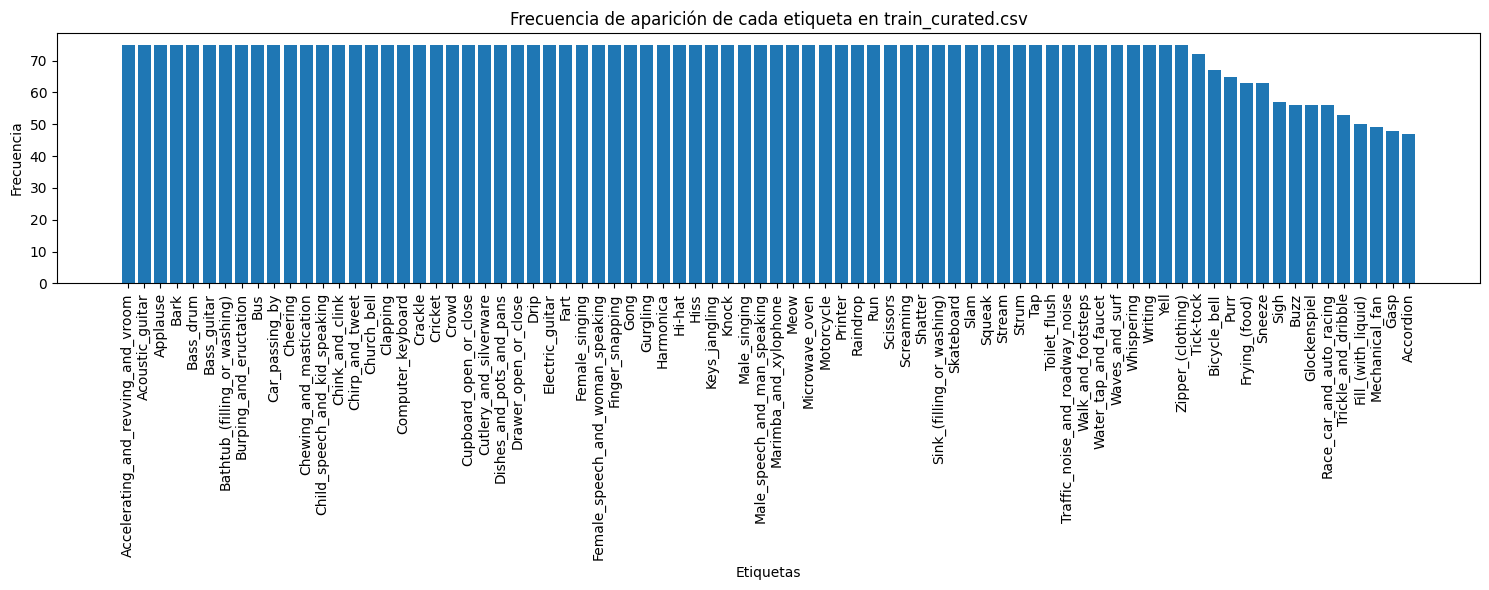

In [ ]:
# Como tenemos una matriz con la información binaria de si una etiqueta está o no, podemos simplemente sumar en las columnas

label_counts = y.sum(axis=0)  # y es la salida de mlb.fit_transform

# Quiero ordenar por qué tan frecuente es cada sonido
# Para eso tengo que asociar cada etiqueta con su frecuencia
label_freq = dict(zip(class_names, label_counts)) # asocio
label_freq_sorted = dict(sorted(label_freq.items(), key=lambda item: item[1], reverse=True)) # ordeno

# Graficar
plt.figure(figsize=(15, 6))
plt.bar(label_freq_sorted.keys(), label_freq_sorted.values())
plt.xticks(rotation=90)
plt.xlabel("Etiquetas")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de aparición de cada etiqueta en train_curated.csv")
plt.tight_layout()
plt.show()

In [ ]:
# Al ver tantas etiquetas con la misma frecuencia, corroboramos que esto efectivamente sea así en el dataset
# Esto es con el objetivo de descartar un posible error al graficar el histograma

unique_counts, counts_freq = np.unique(label_counts, return_counts=True)
for count, freq in zip(unique_counts, counts_freq):
    print(f"{freq} etiquetas aparecen exactamente {count} veces")

1 etiquetas aparecen exactamente 47 veces
1 etiquetas aparecen exactamente 48 veces
1 etiquetas aparecen exactamente 49 veces
1 etiquetas aparecen exactamente 50 veces
1 etiquetas aparecen exactamente 53 veces
3 etiquetas aparecen exactamente 56 veces
1 etiquetas aparecen exactamente 57 veces
2 etiquetas aparecen exactamente 63 veces
1 etiquetas aparecen exactamente 65 veces
1 etiquetas aparecen exactamente 67 veces
1 etiquetas aparecen exactamente 72 veces
66 etiquetas aparecen exactamente 75 veces


El resultado muestra que en los datos efectivamente hay 66 etiquetas que aparecen con la misma frecuencia. Es probable que esto haya sido elección de quienes curaron el dataset para obtener la misma frecuencia en la mayoría de las etiquetas (balancearlo).

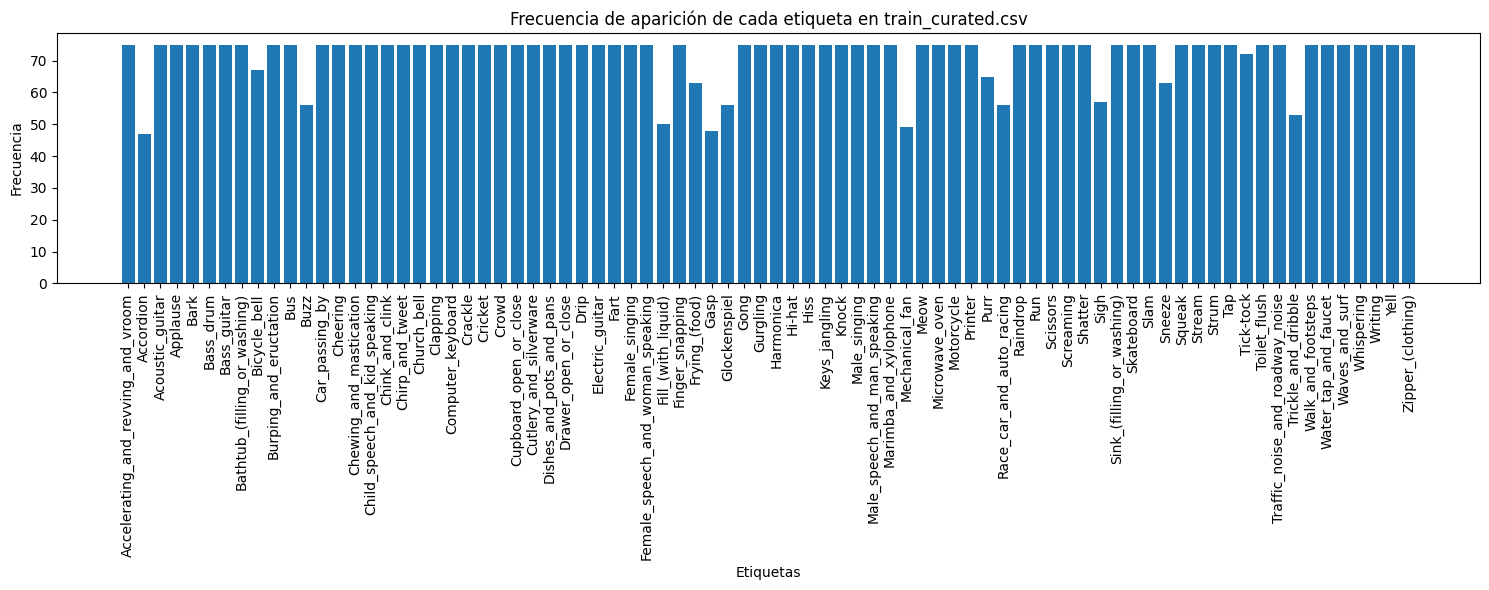

In [ ]:
# Solo por curiosidad, el histograma sin ordenar por frecuencia

# Graficar
plt.figure(figsize=(15, 6))
plt.bar(label_freq.keys(), label_freq.values())
plt.xticks(rotation=90)
plt.xlabel("Etiquetas")
plt.ylabel("Frecuencia")
plt.title("Frecuencia de aparición de cada etiqueta en train_curated.csv")
plt.tight_layout()
plt.show()

## Funciones de procesamiento de los audios

### Procesamiento de los auidos

In [11]:
def load_wav_10s(filename, desired_samples=32000*10):
    # Lee el archivo de audio como binario desde el path indicado
    audio_binary = tf.io.read_file(filename)

    # Decodifica el contenido binario como un archivo WAV
    # `desired_channels=1` fuerza a que sea mono (1 canal)
    waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)

    # Elimina la dimensión de canales para obtener un tensor 1D (samples,)
    waveform = tf.squeeze(waveform, axis=-1)

    # Trunca el audio a la cantidad deseada de muestras (10 segundos si sample_rate=32000)
    waveform = waveform[:desired_samples]

    # Si el audio tiene menos de 10s, agrega ceros al final para completarlo
    zero_padding = tf.zeros([desired_samples] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)

    # Devuelve el audio como un tensor de longitud fija (320000 muestras)
    return waveform

Nota: aca truncamos los audios a 10s, los auidos tienen de 0.3 a 30s. Hay que discutir cual sería una longitud lógica. En gral, lo mejor es que sean todos del mismo largo por el tema de que son NN, pero podemos preguntar.

El siguiente codigo, en vez de truncar 10s a secas calcula donde esta la mayor energía del audio para no cortar el audio por ser descuidadas.

In [21]:
def load_wav_10s_energia(filename, desired_samples=32000*10, hop_samples=32000//2):
    # Leer archivo y decodificar
    audio_binary = tf.io.read_file(filename)
    waveform, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)

    total_samples = tf.shape(waveform)[0]

    # Si es más corto que lo deseado, rellenar con ceros
    if total_samples < desired_samples:
        zero_padding = tf.zeros([desired_samples] - total_samples, dtype=tf.float32)
        waveform = tf.concat([waveform, zero_padding], 0)
        return waveform

    # Si es más largo, escanear con ventanas deslizantes y buscar la de mayor energía
    max_energy = tf.constant(-float("inf"), dtype=tf.float32)
    best_segment = waveform[:desired_samples]  # default al principio

    for i in tf.range(0, total_samples - desired_samples + 1, hop_samples):
        segment = waveform[i:i + desired_samples]
        energy = tf.reduce_sum(tf.square(segment))
        max_energy = tf.maximum(energy, max_energy)
        best_segment = tf.cond(energy > max_energy, lambda: segment, lambda: best_segment)

    return best_segment


### Calculo de el espectrograma

1. Cálculo del espectrograma (STFT)
La primera parte de la función aplica la Transformada de Fourier de corto tiempo (STFT). Esta operación divide la señal de audio en ventanas pequeñas (por ejemplo, de 1024 muestras) y calcula la transformada de Fourier para cada ventana. Esto produce una matriz que representa cómo varía el contenido frecuencial de la señal a lo largo del tiempo, es decir, un espectrograma en escala lineal.

- frame_length define el tamaño de cada ventana de análisis.

- frame_step determina cuánto se avanza entre ventanas consecutivas (también llamado stride).

- fft_length es la cantidad de puntos para la FFT (usualmente igual a frame_length).

Este paso da como resultado una matriz compleja donde cada fila representa una ventana en el tiempo, y cada columna una frecuencia.

2. Conversión de escala lineal a escala Mel
Luego, se transforma el espectrograma de escala lineal (frecuencias distribuidas uniformemente) a la escala Mel, una escala perceptual inspirada en cómo el oído humano percibe las frecuencias: somos más sensibles a las diferencias en frecuencias bajas que en altas.

Para esto:

- Se crea una matriz de conversión que convierte frecuencias lineales en frecuencias Mel. Esta matriz es calculada en función de la cantidad de bins Mel deseados (num_mel_bins), el rango de frecuencias de interés (lower_freq a upper_freq), y la cantidad de frecuencias originales (num_spectrogram_bins).

- Luego, se aplica esta matriz de conversión al espectrograma lineal, usando el producto tensorial (tf.tensordot), que esencialmente realiza una multiplicación matricial para cada frame en el tiempo.

3. Conversión a escala logarítmica
El siguiente paso es llevar los valores del espectrograma Mel a una escala logarítmica, que se alinea mejor con la percepción humana del volumen. Esto es importante porque el oído humano percibe el volumen en forma logarítmica: un aumento lineal en energía no implica un aumento lineal en volumen percibido.

- Se usa tf.math.log, añadiendo una constante pequeña (1e-6) para evitar tomar el logaritmo de cero.

Este paso da como resultado un log-Mel espectrograma: una matriz que muestra cómo cambia la energía en diferentes bandas de frecuencia Mel a lo largo del tiempo, con los valores expresados logarítmicamente.

In [22]:
def waveform_to_log_mel_spectrogram(waveform, sample_rate=32000, frame_length=1024, frame_step=512, num_mel_bins=128, lower_freq=20.0, upper_freq=16000.0):
    # Aplicar la Transformada de Fourier de corto tiempo (STFT) para obtener un espectrograma (tiempo-frecuencia)
    stft = tf.signal.stft(
        waveform,                    # señal de audio
        frame_length=frame_length,  # tamaño de la ventana de análisis (en samples)
        frame_step=frame_step,      # salto entre ventanas (stride)
        fft_length=frame_length     # longitud del FFT (generalmente igual a frame_length)
    )

    # Obtener la magnitud del espectrograma (descarta la fase)
    spectrogram = tf.abs(stft)

    # Calcular el número de bins (frecuencias) en el espectrograma original
    num_spectrogram_bins = spectrogram.shape[-1]

    # Crear una matriz de pesos para convertir de escala lineal a escala Mel
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,               # cantidad de bins Mel deseados
        num_spectrogram_bins,      # cantidad de bins originales (lineales)
        sample_rate,               # frecuencia de muestreo del audio
        lower_freq,                # frecuencia mínima en la escala Mel
        upper_freq                 # frecuencia máxima en la escala Mel
    )

    # Aplicar la matriz de conversión a Mel al espectrograma
    mel_spectrogram = tf.tensordot(
        spectrogram,               # espectrograma original
        linear_to_mel_weight_matrix,  # matriz de conversión
        axes=1                     # aplicar en el eje de frecuencias
    )

    # Establecer explícitamente la forma esperada del espectrograma resultante
    mel_spectrogram.set_shape(
        spectrogram.shape[:-1].concatenate([num_mel_bins])
    )

    # Convertir los valores a escala logarítmica para imitar percepción humana del sonido
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)  # se suma un pequeño valor para evitar log(0)

    # Devolver el espectrograma en escala log-Mel
    return log_mel_spectrogram


In [23]:
def preprocess_file(filename):
    waveform = load_wav_10s_energia(filename)
    logmel = waveform_to_log_mel_spectrogram(waveform)
    return logmel  # shape: (frames, mel_bins)

In [26]:
# Probar con el primero
logmel = preprocess_file(df["filepath"].iloc[5])
print(logmel.shape)  # e.g. (N_frames, 128)

(624, 128)


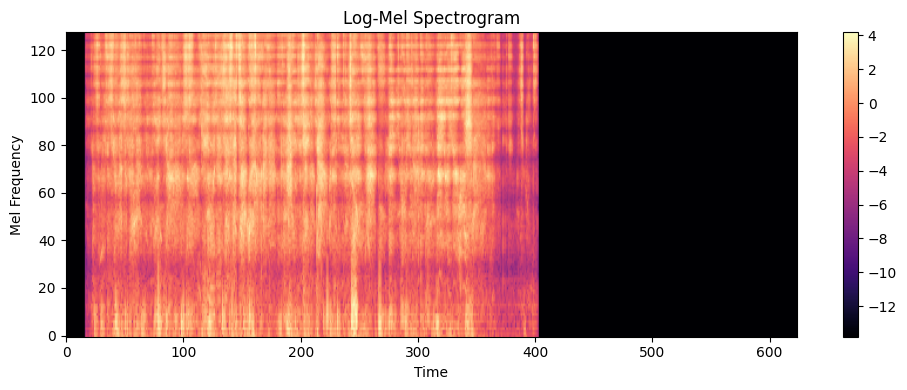

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(tf.transpose(logmel), aspect='auto', origin='lower', cmap='magma')
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar()
plt.tight_layout()
plt.show()

In [29]:
# Crear listas de strings
filepaths = df["filepath"].astype(str).tolist()
labels = y.astype("float32")  # TensorFlow requiere float para etiquetas

# Crear dataset de TensorFlow
ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

# Preprocesar cada elemento
def preprocess(filepath, label):
    logmel = waveform_to_log_mel_spectrogram(load_wav_10s_energia(filepath))
    return logmel, label

# Aplicar el preprocesamiento
AUTOTUNE = tf.data.AUTOTUNE
ds = ds.map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTOTUNE)
ds = ds.batch(32).prefetch(AUTOTUNE)


Las redes convolucionales (Conv2D en Keras/TensorFlow) esperan entradas con 3 dimensiones por muestra, típicamente en formato (alto, ancho, canales), como una imagen:

In [ ]:
#agregar otra dimesion logmel = tf.expand_dims(logmel, -1)  # shape: (625, 128, 1) para CNN

Ahora veamos 5 espectogramas random

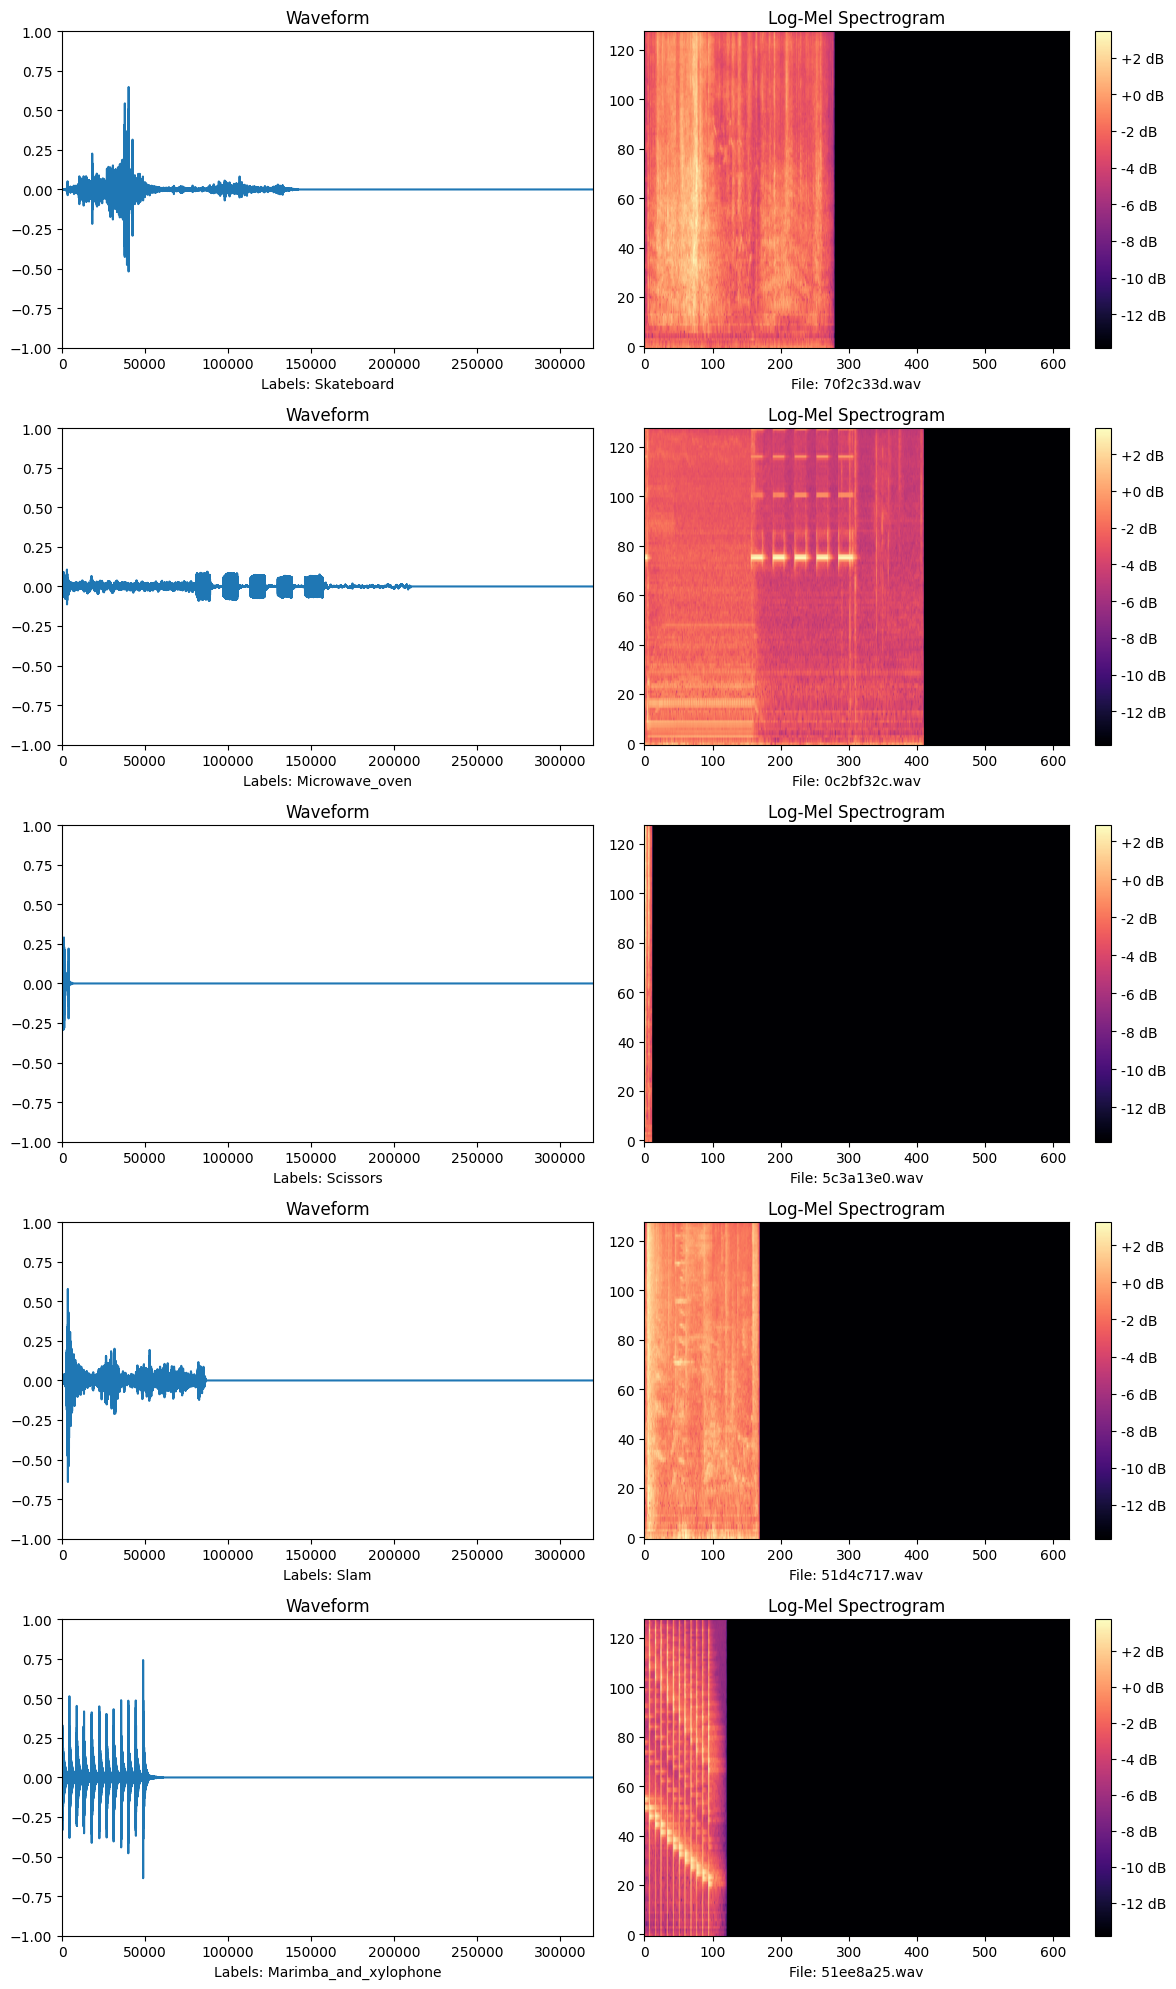

In [32]:
# Elegir 5 muestras aleatorias del DataFrame
sample_rows = df.sample(5, random_state=32)

samples_processed = []

for _, row in sample_rows.iterrows():
    filepath = row["filepath"]
    labels_list = row["labels"]

    # Cargar waveform y espectrograma
    waveform = load_wav_10s_energia(filepath).numpy()  # Tensor -> numpy
    logmel = waveform_to_log_mel_spectrogram(tf.constant(waveform)).numpy()  # Tensor -> numpy

    samples_processed.append((waveform, logmel, labels_list, filepath))

# Funciones para graficar

def plot_waveform(waveform, ax):
    ax.plot(waveform)
    ax.set_title("Waveform")
    ax.set_ylim([-1, 1])
    ax.set_xlim([0, len(waveform)])

def plot_logmel_spectrogram(logmel, ax):
    img = ax.imshow(logmel.T, aspect='auto', origin='lower', cmap='magma')
    ax.set_title("Log-Mel Spectrogram")
    plt.colorbar(img, ax=ax, format="%+2.0f dB")

# Crear figura para 5 muestras, 2 columnas (waveform y espectrograma)
fig, axs = plt.subplots(5, 2, figsize=(12, 20))

for i, (waveform, logmel, labels, filepath) in enumerate(samples_processed):
    plot_waveform(waveform, axs[i, 0])
    plot_logmel_spectrogram(logmel, axs[i, 1])

    axs[i, 0].set_xlabel("Labels: " + ", ".join(labels))
    axs[i, 1].set_xlabel("File: " + filepath.split('/')[-1])

plt.tight_layout()
plt.show()


Nota: Sara habló de variar la ventana etc, habria que explorar eso también

### MFCCs

Los Mel-Frequency Cepstral Coefficients (MFCC) son representaciones compactas de las características del audio. Lo que se hace es una transformada discreta del coseno (DCT) al Log-Mel-spectogram que se calculó previamente.

Para cada ventana (frame) de audio en el tiempo, se calcula un vector de coeficientes que resume la forma espectral.

La DCT transforma el espectro Log-Mel (que tiene, por ejemplo, 128 bandas de frecuencia) en un conjunto de valores ordenados por importancia energética (los primeros representan la forma general, los últimos, el detalle fino o ruido).

In [33]:
# Veamos los primeros 13 coeficientes
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(logmel)[..., :13]

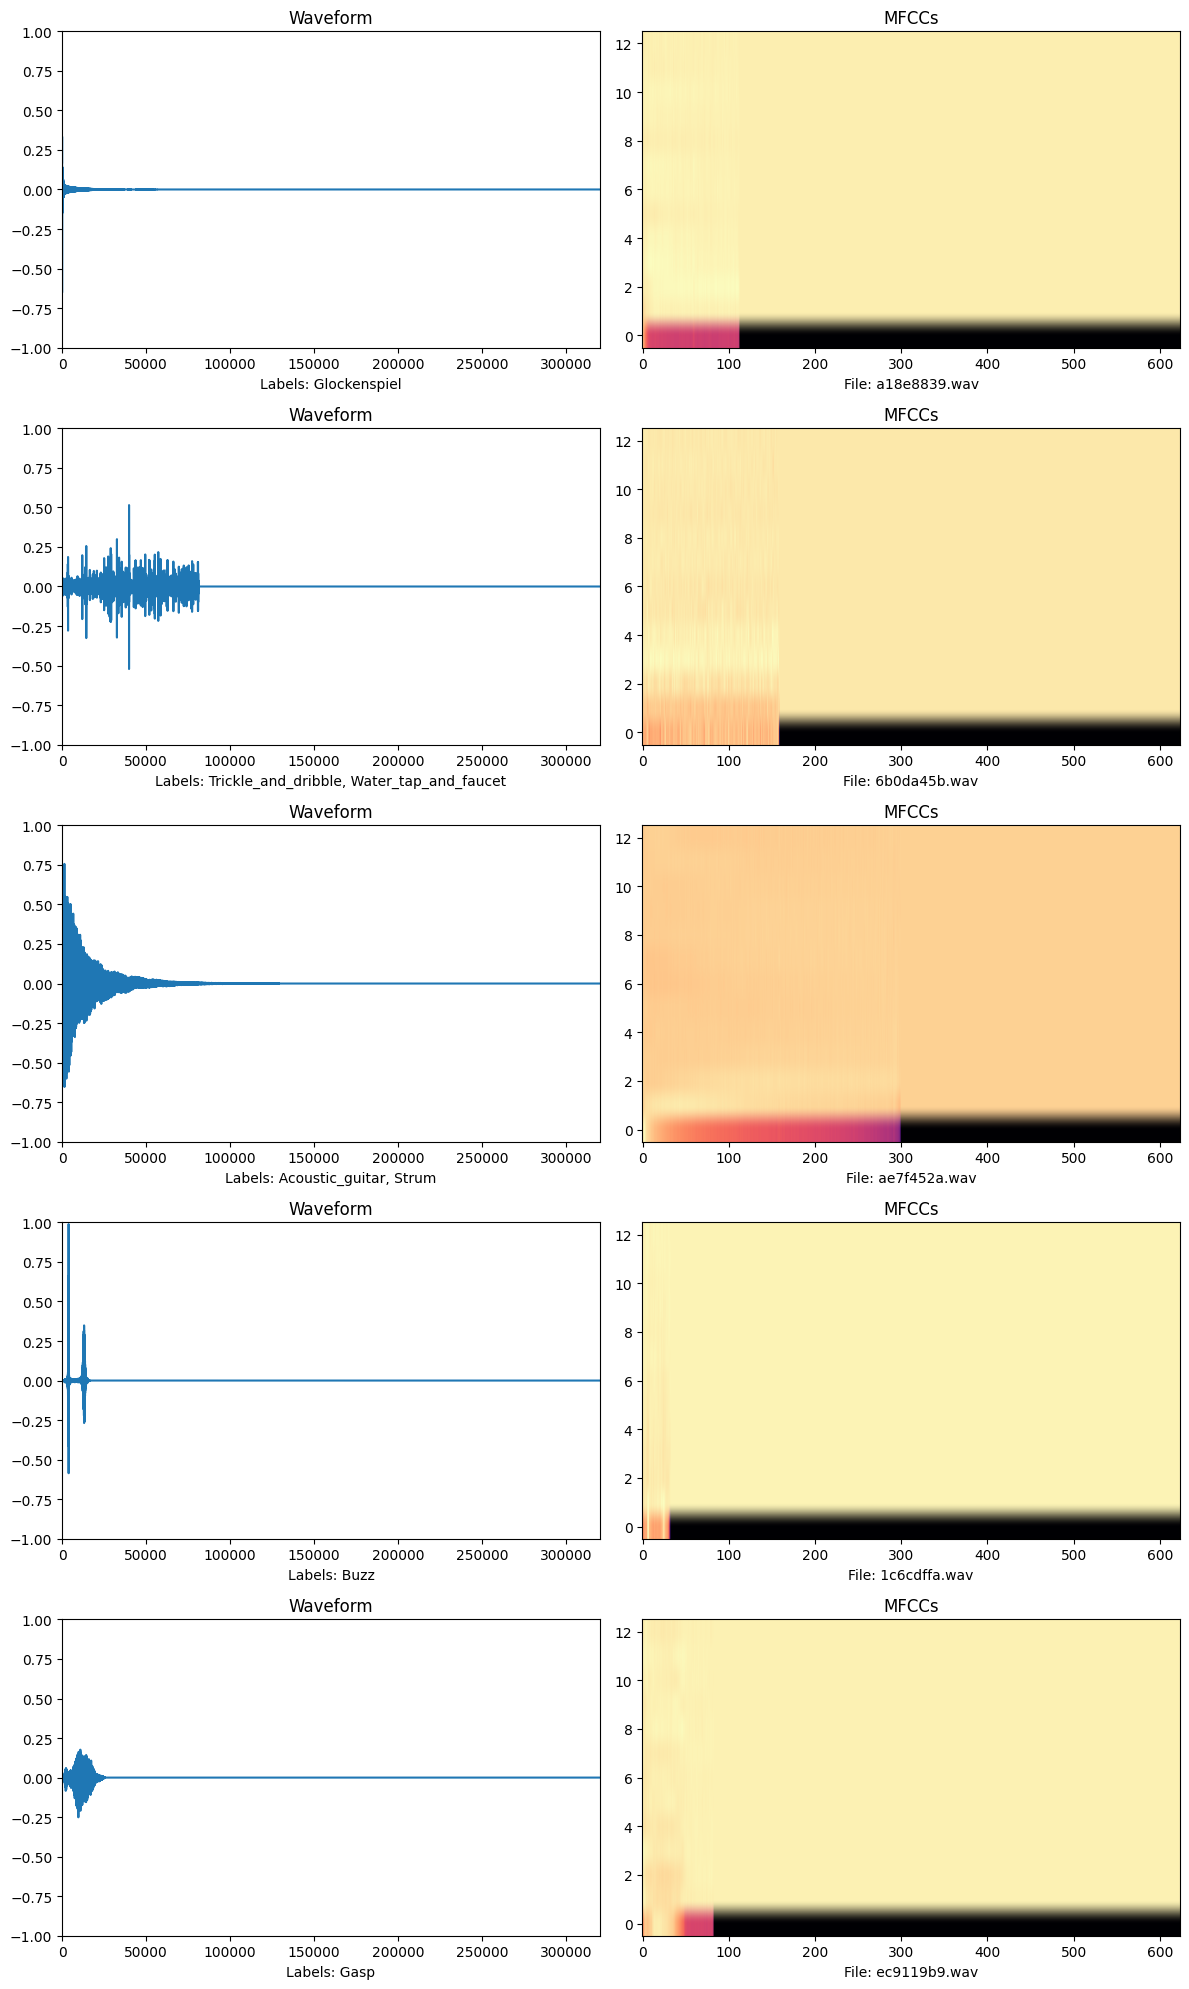

In [35]:
# Elegir 5 muestras aleatorias del DataFrame
sample_rows = df.sample(5, random_state=2)

samples_processed = []

for _, row in sample_rows.iterrows():
    filepath = row["filepath"]
    labels_list = row["labels"]

    # Cargar waveform y mfcc
    waveform = load_wav_10s_energia(filepath).numpy()  # Tensor -> numpy
    logmel = waveform_to_log_mel_spectrogram(tf.constant(waveform)).numpy()  # Tensor -> numpy
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(logmel)[..., :13]
    mfccs_np = mfccs.numpy()

    samples_processed.append((waveform, mfccs_np, labels_list, filepath))

# Funciones para graficar

# Ya está definida arriba
#def plot_waveform(waveform, ax):
#    ax.plot(waveform)
#    ax.set_title("Waveform")
#    ax.set_ylim([-1, 1])
#    ax.set_xlim([0, len(waveform)])

def plot_mfccs(mfccs, ax):
    img = ax.imshow(mfccs.T, aspect='auto', origin='lower', cmap='magma')
    ax.set_title("MFCCs")

# Crear figura para 5 muestras, 2 columnas (waveform y espectrograma)
fig, axs = plt.subplots(5, 2, figsize=(12, 20))

for i, (waveform, mfccs_np, labels, filepath) in enumerate(samples_processed):
    plot_waveform(waveform, axs[i, 0])
    plot_mfccs(mfccs_np, axs[i, 1])

    axs[i, 0].set_xlabel("Labels: " + ", ".join(labels))
    axs[i, 1].set_xlabel("File: " + filepath.split('/')[-1])

plt.tight_layout()
plt.show()


## samp_rate, frame_length, hop_length, n_mels y duración del audio

| Parámetro      | Valores típicos a probar                   |
| -------------- | ------------------------------------------ |
| `sample_rate`  | 16000, **32000**, 44100 Hz                 |
| `frame_length` | 512, **1024**, 2048                        |
| `hop_length`   | 128, 256, **512**, 768                     |
| `n_mels`       | 64, **128**, 256                           |
| `duración`     | 3 s, 5 s, **10 s** (con padding o recorte) |


sample_rate controla la cantidad de muestras por segundo en el audio. Si usás 16000 Hz el archivo es más liviano y rápido de procesar, pero perdés frecuencias por encima de 8 kHz. Es ideal para voz o sonidos simples. Con 32000 Hz tenés un buen equilibrio entre detalle y peso, y se usa mucho en tareas de clasificación de audio general como en AudioSet. Con 44100 Hz tenés máxima fidelidad, útil si tus sonidos tienen mucho contenido en altas frecuencias como música o instrumentos, pero los archivos son más pesados.

frame_length es el tamaño de la ventana para calcular la transformada rápida de Fourier STFT. Ventanas pequeñas como 512 muestras te dan buena resolución en el tiempo, lo que es útil si los eventos son breves o percusivos, pero te dan poca resolución en frecuencia. Ventanas más grandes como 2048 te dan mejor resolución en frecuencia, útil para detectar notas musicales o ambientes sostenidos, pero empeora la resolución temporal. Un valor intermedio como 1024 es un equilibrio común y razonable.

frame_step indica cada cuántas muestras se aplica una nueva ventana. Si lo hacés muy chico como 256 vas a tener muchas ventanas por segundo, con más detalle temporal pero más carga computacional. Si lo hacés muy grande como 1024 te ahorrás cálculos, pero podés perder eventos rápidos. Un valor habitual es la mitad del frame_length, por ejemplo frame_length 1024 y frame_step 512.

n_mels es el número de bandas Mel que usás para comprimir la información espectral en forma perceptual. Si usás 64 bandas tenés una representación compacta y rápida, pero se pierde detalle. 128 bandas es una opción balanceada y muy común para redes convolucionales. 256 bandas te da máxima resolución espectral perceptual, pero implica mayor memoria y riesgo de overfitting si el modelo es chico o el dataset limitado.

La duración del audio afecta cuánto contexto se ve por muestra. Si usás 3 o 5 segundos estás enfocándote en eventos rápidos y locales, con inputs más pequeños. Usar 10 segundos es una opción muy común para clasificar sonidos naturales, ya que ofrece buen contexto sin hacer los tensores demasiado grandes. Usar 30 segundos puede ser útil si los eventos son largos y variados, pero el modelo se vuelve mucho más lento y pesado.

En resumen se elige el sample_rate según la importancia de las frecuencias altas en los sonidos, frame_length según si interesa más el detalle temporal o espectral, frame_step como proporción de la ventana, n_mels según cuánta resolución se quiere en el eje de frecuencia, y duración según el tipo de eventos y el tamaño aceptable de input.

## Conjuntos de validación y train

In [ ]:
# División aleatoria (80% entrenamiento, 20% validación)
df_train, df_val, y_train, y_val = train_test_split(
    df["filepath"], y, test_size=0.2, random_state=42
)

In [ ]:
df_train.head()

,filepath
1477,/content/drive/MyDrive/Proyecto2_TAA/train_cur...
4055,/content/drive/MyDrive/Proyecto2_TAA/train_cur...
2218,/content/drive/MyDrive/Proyecto2_TAA/train_cur...
4103,/content/drive/MyDrive/Proyecto2_TAA/train_cur...
80,/content/drive/MyDrive/Proyecto2_TAA/train_cur...


In [ ]:
mlb.inverse_transform(y_val[:5])

[('Toilet_flush',),
 ('Burping_and_eructation',),
 ('Motorcycle',),
 ('Run',),
 ('Male_speech_and_man_speaking',)]

## COMET

Cosas que vamos a querer subir a comet, para poder comparar casos. Además, cómo vamos a llamar a los casos. También, que gráficas queremos
Sabiendo que vamos a usar Redes Neuronales propongo guardar:

Hiperparámetros:

- Learning rate
- tipo de optimizador: Adam, SGD
- Batch normalization si o no (sugiero subir a mano si decidimos cambiar el batch_size)
- Inicializacion: he normal, glorot_uniform, etc
- Tipo: fully connected, red convolucional, otros
- Épocas de entrenamiento
- n_hidden
- n_neurons
- activación
- Si es convolucional, cuantos bloques

Metrics:
- Val loss por época
- Train loss por época
- Val loss + train loss por época
- Val Accuracy, train accuracy
- Val f1-score, train f1-score
- Métrica del problema val y train

Gráficas:
- de todas las métricas

Nombres:
- Fully Connected
- Red Convolucional
- etc

Labels:
- fully_connected, convolucional, adam, sgd, batch_norm, he_normal, glorot_uniform

In [ ]:
def entrenar_y_loguear(model_fn, model_args, X_train, y_train, X_val, y_val,
                       experiment_name, project_name="fashion-mnist", epochs=10,
                       tags=[], comet_api_key=None, batch_size=32):

    # Crear experimento
    experiment = Experiment(
        api_key=comet_api_key,
        project_name=project_name,
    )
    experiment.set_name(experiment_name)
    experiment.add_tags(tags)

    # Crear el modelo
    model = model_fn(**model_args)

    # Loguear hiperparámetros de arquitectura
    experiment.log_parameter("learning_rate", model_args.get("learning_rate"))
    experiment.log_parameter("optimizer", model_args.get("optimizer"))
    experiment.log_parameter("activation", model_args.get("activation"))
    experiment.log_parameter("n_hiddens", model_args.get("n_hiddens"))
    experiment.log_parameter("n_neurons", model_args.get("n_neurons"))
    experiment.log_parameter("batch_norm", model_args.get("batch_norm", False))

    # Si es CNN
    if "N" in model_args:
        experiment.log_parameter("conv_blocks", model_args["N"])


    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        verbose=2
    )

    # Loguear métricas por época
    for epoch in range(epochs):
        experiment.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        experiment.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        experiment.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        experiment.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)

    experiment.end()
    return history
